In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import geopandas as gpd
import timeit
import geopy.distance
import numpy as np
import math
import matplotlib.pyplot as plt
from shapely.geometry import Point, MultiPoint, Polygon, LineString
import shapely.wkt
import random
from pyproj import Proj, transform #Convertion EPSG2154 to WGS84

from datetime import datetime

In [2]:
#calcualtes distance between two spherical coordiantes
def distance(p1, p2):
    return geopy.distance.distance(p1, p2).km

#calcualtes distance between two euclidean coordinates
def distance_euc(p1, p2):
    return math.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

#calcualtes distance between two euclidean coordinates
def distance_euc_Point(p1, p2):
    return math.sqrt((p2.x - p1.x)**2 + (p2.y - p1.y)**2)

def closest(pt, others, real_dist):
    return min(others, key = lambda i: abs(distance(pt, i) - real_dist))

def closest_home(a, b, real_dist):
    e = [(Pa, Pb) for Pa in a for Pb in b]
    return(e[np.argmin([abs(distance(Pa, Pb) - real_dist) for (Pa, Pb) in e])])

def closest_euc(pt, others, real_dist):
    return min(others, key = lambda i: abs(distance_euc_Point(pt, i) - real_dist))

def closest_home_euc(a, b, real_dist):
    e = [(Pa, Pb) for Pa in a for Pb in b]
    return(e[np.argmin([abs(distance_euc_Point(Pa, Pb) - real_dist) for (Pa, Pb) in e])])

##New function checking directly if the point lies to the polygon
def generate_random_points(sample_point, seed, polygon):
    random = np.random.RandomState(seed)
    points = []
    minx, miny, maxx, maxy = polygon.bounds
    while len(points) < sample_point:
        pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if polygon.contains(pnt):
            points.append(pnt)
    return points

## Loading files

In [3]:
### Taxis locations
df_taxis_locations = gpd.read_file("/media/aodiallo/Data/MATSIM/Simulation/robotaxi/input/taxis/shapes/taxis_stations_location.shp")

In [4]:
df_taxis_locations

,nom,adresse,commune,nbemplacem,telephone,separateur,abri,panneau,diodes,totem,gid,geometry
0,TAX901,Rue de la Pépinière Royale,Lyon 9 ème,2.0,Non,Autre,Non,Oui,Non,Non,1,POINT (840278.506 6520207.192)
1,TAXSFO01,Rue Charles Plasse,SAINT-FONS,3.0,Non,Bordure granit,Non,Oui,Non,Non,2,POINT (844187.300 6513847.712)
2,TAX312,Rue Aimé Collomb,Lyon 3 ème,4.0,Non,Peinture,Non,Oui,Non,Non,3,POINT (843209.601 6519131.609)
3,TAXVIL03,"158, Rue Léon Blum",VILLEURBANNE,4.0,Non,Bordure granit,Non,Oui,Non,Oui,4,POINT (848171.856 6519672.127)
4,TAXRIL02,"79b, Avenue de l'Europe",RILLIEUX-LA-PAPE,3.0,Non,Bordure granit,Non,Oui,Non,Non,5,POINT (847709.139 6526028.936)
...,...,...,...,...,...,...,...,...,...,...,...,...
105,TAXNEU01,Quai Pasteur,NEUVILLE-SUR-SAONE,4.0,Oui,Peinture,Oui,Oui,Non,Non,106,POINT (842577.930 6532441.797)
106,TAX902,Rue Roger Salengro,Lyon 9 ème,5.0,Non,Bordure granit,Non,Oui,Non,Oui,107,POINT (840161.083 6521569.811)
107,TAX703,"16, Place Docteurs Charles et Christophe Mérieux",Lyon 7 ème,10.0,Non,Bordure granit,Non,Oui,Non,Oui,108,POINT (841987.094 6516362.568)
108,TAX904,"Face 8, Rue de la Navigation",Lyon 9 ème,4.0,Non,Bordure granit,Non,Oui,Non,Oui,109,POINT (840806.858 6522555.134)


In [6]:
### Grand Lyon Network
df_net = gpd.read_file("/media/aodiallo/Data/MATSIM/Simulation/robotaxi/input/network/shapes/grand_lyon_network.shp")

In [7]:
df_net

,ID,FROM,TO,LENGTH,CAPACITY,LANES,MODES,FRSPEED,geometry
0,57123,477747006,307632687,14.572248,600.0,1.0,"car_passenger,car",6.944444,"LINESTRING (849770.296 6508486.761, 849763.469..."
1,24796,1874062239,1874062216,325.549853,600.0,1.0,"car_passenger,car",6.944444,"LINESTRING (849405.190 6510213.614, 849462.166..."
2,65455,245971931,245972040,132.300956,600.0,1.0,"car_passenger,car",4.166667,"LINESTRING (852229.637 6517498.498, 852276.938..."
3,24896,1365357440,2576693208,34.024915,600.0,1.0,"car_passenger,car",4.166667,"LINESTRING (845481.393 6515416.359, 845464.893..."
4,10446,306815314,1500301895,279.074159,600.0,1.0,"car_passenger,car",4.166667,"LINESTRING (839617.869 6508829.142, 839887.014..."
...,...,...,...,...,...,...,...,...,...
74106,52561,2334374862,1460282444,17.569616,600.0,1.0,"car_passenger,car",6.944444,"LINESTRING (835001.397 6531052.854, 835018.935..."
74107,45656,6726742630,4646178430,19.599083,600.0,1.0,"car_passenger,car,bus",13.888889,"LINESTRING (843111.563 6506276.676, 843097.501..."
74108,86261,307819003,888104530,42.013541,600.0,1.0,"car_passenger,car",13.888889,"LINESTRING (847808.674 6509461.417, 847844.708..."
74109,20057,95836805,2161903849,38.300236,1000.0,1.0,"pt,car,car_passenger,bus",13.888889,"LINESTRING (843198.590 6517865.301, 843213.437..."


In [8]:
df_net["MODES"].unique()

array(['car_passenger,car', 'pt,car,car_passenger,bus', 'artificial,bus',
       'artificial,tram,stopFacilityLink', 'car_passenger,car,bus',
       'pt,bus', 'tram,artificial', 'artificial,subway,stopFacilityLink',
       'artificial,bus,stopFacilityLink', 'subway,artificial',
       'tram,bus,pt', 'pt,subway', 'artificial,funicular',
       'artificial,funicular,stopFacilityLink'], dtype=object)

In [9]:
## Just select the links whose are allowed car
f = df_net["MODES"] == 'car_passenger,car'
f |= df_net["MODES"] == 'pt,car,car_passenger,bus'
f |= df_net["MODES"] == 'car_passenger,car,bus'

In [12]:
df_net_car = df_net[f]

In [13]:
df_net_car

,ID,FROM,TO,LENGTH,CAPACITY,LANES,MODES,FRSPEED,geometry
0,57123,477747006,307632687,14.572248,600.0,1.0,"car_passenger,car",6.944444,"LINESTRING (849770.296 6508486.761, 849763.469..."
1,24796,1874062239,1874062216,325.549853,600.0,1.0,"car_passenger,car",6.944444,"LINESTRING (849405.190 6510213.614, 849462.166..."
2,65455,245971931,245972040,132.300956,600.0,1.0,"car_passenger,car",4.166667,"LINESTRING (852229.637 6517498.498, 852276.938..."
3,24896,1365357440,2576693208,34.024915,600.0,1.0,"car_passenger,car",4.166667,"LINESTRING (845481.393 6515416.359, 845464.893..."
4,10446,306815314,1500301895,279.074159,600.0,1.0,"car_passenger,car",4.166667,"LINESTRING (839617.869 6508829.142, 839887.014..."
...,...,...,...,...,...,...,...,...,...
74106,52561,2334374862,1460282444,17.569616,600.0,1.0,"car_passenger,car",6.944444,"LINESTRING (835001.397 6531052.854, 835018.935..."
74107,45656,6726742630,4646178430,19.599083,600.0,1.0,"car_passenger,car,bus",13.888889,"LINESTRING (843111.563 6506276.676, 843097.501..."
74108,86261,307819003,888104530,42.013541,600.0,1.0,"car_passenger,car",13.888889,"LINESTRING (847808.674 6509461.417, 847844.708..."
74109,20057,95836805,2161903849,38.300236,1000.0,1.0,"pt,car,car_passenger,bus",13.888889,"LINESTRING (843198.590 6517865.301, 843213.437..."


In [14]:
net_links = list(df_net_car["geometry"].values)

In [15]:
#net_links = list(df_net_car["geometry"].unique)

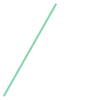

In [16]:
net_links[0]

In [17]:
df_net_car[df_net_car["geometry"] == net_links[6]].index

Int64Index([6], dtype='int64')

In [18]:
## Sources codes : https://stackoverflow.com/questions/70626218/how-to-find-the-nearest-linestring-to-a-point
def closest_line(links, point):
    # get distances
    distance_list = [line.distance(point) for line in links]
    shortest_distance = min(distance_list) # find the line closest to the point
    return links[distance_list.index(shortest_distance)] # return the closest line

def closest_line_with_distance(links, point):
    # get distances
    distance_list = [line.distance(point) for line in links]
    shortest_distance = min(distance_list) # find the line closest to the point
    return(links[distance_list.index(shortest_distance)], # return the closest line
           shortest_distance) # return the distance to that line

In [17]:
### Other solution
'''
line_string = ["LINESTRING (-1.15 9.9, -1.15 9.93)", "LINESTRING (-2.15 8.9, -2.15 8.93)"]
point = "POINT (5.41 3.9)"

gdf_p = gpd.GeoDataFrame(geometry=[shapely.wkt.loads(point)])
gdf_l = gpd.GeoDataFrame(geometry=pd.Series(line_string).apply(shapely.wkt.loads))

df_n = gpd.sjoin_nearest(gdf_p, gdf_l).merge(gdf_l, left_on="index_right", right_index=True)

df_n["distance"] = df_n.apply(lambda r: r["geometry_x"].distance(r["geometry_y"]), axis=1)

df_n
'''

'\nline_string = ["LINESTRING (-1.15 9.9, -1.15 9.93)", "LINESTRING (-2.15 8.9, -2.15 8.93)"]\npoint = "POINT (5.41 3.9)"\n\ngdf_p = gpd.GeoDataFrame(geometry=[shapely.wkt.loads(point)])\ngdf_l = gpd.GeoDataFrame(geometry=pd.Series(line_string).apply(shapely.wkt.loads))\n\ndf_n = gpd.sjoin_nearest(gdf_p, gdf_l).merge(gdf_l, left_on="index_right", right_index=True)\n\ndf_n["distance"] = df_n.apply(lambda r: r["geometry_x"].distance(r["geometry_y"]), axis=1)\n\ndf_n\n'

In [19]:
## Start time
t1 = datetime.now()

In [20]:
#Links id reconstruction
n_slice = len(df_taxis_locations)
indices = list(range(n_slice))
taxi_links = []
index_links = []

#bounding box for O/D zones fines for each trip
for i in indices:
    link = closest_line(net_links, df_taxis_locations["geometry"][i])
    index = df_net_car[df_net_car["geometry"] == link].index
    taxi_links.append(link) 
    index_links.append(index[0])

In [21]:
## End time
t2 = datetime.now()
print(str(t2-t1))

0:04:37.774709


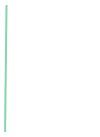

In [22]:
taxi_links[0]

In [23]:
## Select only rows of df_net whose correspond to taxis stations locations
df_net_taxis = df_net_car.iloc[index_links,:]

In [24]:
df_net_taxis

,ID,FROM,TO,LENGTH,CAPACITY,LANES,MODES,FRSPEED,geometry
23523,51451,279631461,298632260,320.296434,600.0,1.0,"car_passenger,car",6.944444,"LINESTRING (849148.155 6515120.793, 849223.415..."
64553,24884,1127807444,5092178749,114.149487,600.0,1.0,"pt,car,car_passenger,bus",13.888889,"LINESTRING (843320.582 6506576.511, 843255.143..."
26769,70751,33183232,23667059,55.182476,600.0,1.0,"car_passenger,car",8.333333,"LINESTRING (842030.646 6518795.655, 842052.512..."
40319,44208,2977555020,2868281890,78.886178,600.0,1.0,"car_passenger,car,bus",6.944444,"LINESTRING (835365.213 6530880.795, 835360.511..."
31822,10216,33116039,492460101,71.705158,600.0,1.0,"car_passenger,car",6.944444,"LINESTRING (840821.389 6518941.883, 840844.684..."
...,...,...,...,...,...,...,...,...,...
50168,4042,430143394,437008503,249.846267,600.0,1.0,"car_passenger,car",6.944444,"LINESTRING (845169.008 6513114.808, 845228.912..."
10040,48959,428130805,428130803,42.232966,600.0,1.0,"car_passenger,car",4.166667,"LINESTRING (854952.661 6521325.006, 854949.910..."
6013,4259,2074767467,25271522,52.064661,1000.0,1.0,"pt,car,car_passenger,bus",19.444444,"LINESTRING (838669.969 6519709.978, 838642.348..."
31838,13512,2465004217,2465004202,97.212855,600.0,1.0,"car_passenger,car",4.166667,"LINESTRING (843981.055 6516339.351, 844062.427..."


In [25]:
link_id = df_net_taxis["ID"].values.astype(int)

In [26]:
link_id

array([51451, 24884, 70751, 44208, 10216, 23594, 65759, 87917, 17668,
       75075, 63138, 28028, 12596, 15478, 60909, 60167, 73280, 79803,
       88118, 63411,  2259, 54324,  9443, 16953, 41460, 11091,  7587,
       59068, 58892, 29156, 46143, 38706, 72337, 22954, 70541, 16995,
       28729, 50864, 48970, 74877, 36905, 16316,  6828, 58891, 32692,
       58284, 16931,  3090, 68692, 81762,  3834,  2425, 47141, 69292,
       29452, 10287, 23614, 35136, 85928, 33112, 74441, 57735,  8642,
       42724, 33558, 69978, 87622, 56919,  8821, 76600, 79121, 21299,
       82756, 77927, 50073, 35473, 21218, 18448, 53387, 34389, 25005,
       35345, 43614, 72139,  5781, 86269, 79632, 56858,  7653, 41054,
       57735, 15134, 35869,  1820, 74874, 12353, 37368, 65964, 47802,
       26149, 47802, 80333, 28615,  1193,  5590,  4042, 48959,  4259,
       13512, 48208])

In [27]:
## Complete the taxis data
df_taxis_locations["link"] = taxi_links

In [28]:
df_taxis_locations

,nom,adresse,commune,nbemplacem,telephone,separateur,abri,panneau,diodes,totem,gid,geometry,link
0,TAX901,Rue de la Pépinière Royale,Lyon 9 ème,2.0,Non,Autre,Non,Oui,Non,Non,1,POINT (840278.506 6520207.192),LINESTRING (840301.1588493029 6520331.08429506...
1,TAXSFO01,Rue Charles Plasse,SAINT-FONS,3.0,Non,Bordure granit,Non,Oui,Non,Non,2,POINT (844187.300 6513847.712),LINESTRING (844226.0349661598 6513836.70919504...
2,TAX312,Rue Aimé Collomb,Lyon 3 ème,4.0,Non,Peinture,Non,Oui,Non,Non,3,POINT (843209.601 6519131.609),LINESTRING (843182.5186245841 6519147.71246535...
3,TAXVIL03,"158, Rue Léon Blum",VILLEURBANNE,4.0,Non,Bordure granit,Non,Oui,Non,Oui,4,POINT (848171.856 6519672.127),LINESTRING (848108.9061020506 6519670.51450241...
4,TAXRIL02,"79b, Avenue de l'Europe",RILLIEUX-LA-PAPE,3.0,Non,Bordure granit,Non,Oui,Non,Non,5,POINT (847709.139 6526028.936),LINESTRING (847765.5656705137 6526052.80299619...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,TAXNEU01,Quai Pasteur,NEUVILLE-SUR-SAONE,4.0,Oui,Peinture,Oui,Oui,Non,Non,106,POINT (842577.930 6532441.797),LINESTRING (842578.6911077248 6532469.04649189...
106,TAX902,Rue Roger Salengro,Lyon 9 ème,5.0,Non,Bordure granit,Non,Oui,Non,Oui,107,POINT (840161.083 6521569.811),LINESTRING (840182.0339989121 6521553.87081078...
107,TAX703,"16, Place Docteurs Charles et Christophe Mérieux",Lyon 7 ème,10.0,Non,Bordure granit,Non,Oui,Non,Oui,108,POINT (841987.094 6516362.568),LINESTRING (841991.3932604335 6516438.16012393...
108,TAX904,"Face 8, Rue de la Navigation",Lyon 9 ème,4.0,Non,Bordure granit,Non,Oui,Non,Oui,109,POINT (840806.858 6522555.134),LINESTRING (840824.4486077658 6522547.24456913...


In [29]:
df_taxis_locations["link_id"] = link_id

In [30]:
df_taxis_locations

,nom,adresse,commune,nbemplacem,telephone,separateur,abri,panneau,diodes,totem,gid,geometry,link,link_id
0,TAX901,Rue de la Pépinière Royale,Lyon 9 ème,2.0,Non,Autre,Non,Oui,Non,Non,1,POINT (840278.506 6520207.192),LINESTRING (840301.1588493029 6520331.08429506...,51451
1,TAXSFO01,Rue Charles Plasse,SAINT-FONS,3.0,Non,Bordure granit,Non,Oui,Non,Non,2,POINT (844187.300 6513847.712),LINESTRING (844226.0349661598 6513836.70919504...,24884
2,TAX312,Rue Aimé Collomb,Lyon 3 ème,4.0,Non,Peinture,Non,Oui,Non,Non,3,POINT (843209.601 6519131.609),LINESTRING (843182.5186245841 6519147.71246535...,70751
3,TAXVIL03,"158, Rue Léon Blum",VILLEURBANNE,4.0,Non,Bordure granit,Non,Oui,Non,Oui,4,POINT (848171.856 6519672.127),LINESTRING (848108.9061020506 6519670.51450241...,44208
4,TAXRIL02,"79b, Avenue de l'Europe",RILLIEUX-LA-PAPE,3.0,Non,Bordure granit,Non,Oui,Non,Non,5,POINT (847709.139 6526028.936),LINESTRING (847765.5656705137 6526052.80299619...,10216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,TAXNEU01,Quai Pasteur,NEUVILLE-SUR-SAONE,4.0,Oui,Peinture,Oui,Oui,Non,Non,106,POINT (842577.930 6532441.797),LINESTRING (842578.6911077248 6532469.04649189...,4042
106,TAX902,Rue Roger Salengro,Lyon 9 ème,5.0,Non,Bordure granit,Non,Oui,Non,Oui,107,POINT (840161.083 6521569.811),LINESTRING (840182.0339989121 6521553.87081078...,48959
107,TAX703,"16, Place Docteurs Charles et Christophe Mérieux",Lyon 7 ème,10.0,Non,Bordure granit,Non,Oui,Non,Oui,108,POINT (841987.094 6516362.568),LINESTRING (841991.3932604335 6516438.16012393...,4259
108,TAX904,"Face 8, Rue de la Navigation",Lyon 9 ème,4.0,Non,Bordure granit,Non,Oui,Non,Oui,109,POINT (840806.858 6522555.134),LINESTRING (840824.4486077658 6522547.24456913...,13512


In [32]:
export_csv = df_taxis_locations.to_csv(r'/media/aodiallo/Data/MATSIM/Simulation/robotaxi/input/taxis/taxis_stations_with_net_link.csv', index=None, header=True)

In [33]:
df_taxis_locations["nbemplacem"].sum()

597.0